# Sentiment Analysis of Tweets Dataset using the following Machine Learning models
- Logistic Regression
- Random Forest Classifier
- Extra Trees Classifier
- Ada Boost Classifier
- Naive Bayes

In [1]:
# import required libraries
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import string

In [2]:
# download punctuation and stopwords from nltk
nltk.download('punkt')
nltk.download("stopwords")
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\apfle\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\apfle\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\apfle\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\apfle\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

# Transform the data

In [3]:
# load tweets_df and view
tweets_df = pd.read_csv("Resources/Tweets.csv")
tweets_df

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive


In [4]:
# get dataframe ready for processing

# make sure the tweets in column "text" are strings
tweets_df['text'] = tweets_df['text'].astype('str')

# delete the unneccessary columns
tweets_df = tweets_df.drop(columns=["textID", "selected_text"])

In [5]:
def process_tweets(tweet):
    # make the text all lowercase
    tweet = tweet.lower()
    
    # remove punctuation
    tweet = "".join(char for char in tweet if char not in string.punctuation)
    
    # tokenize the tweet for url clean
    tokenize_tweet_url = word_tokenize(tweet)
    
    # remove urls
    tokenize_tweet_url = " ".join([i for i in tokenize_tweet_url if 'http' not in i])
    
    # tokenize the tweet
    tokenize_tweets = word_tokenize(tokenize_tweet_url)
    
    # remove stopwords
    stopword = stopwords.words("english")
    tweet_wo_stop = [word for word in tokenize_tweets if word not in stopword]
    
    # lemmatization
    lemm = WordNetLemmatizer()
    lemmed = [lemm.lemmatize(word) for word in tweet_wo_stop]
    
    # put string together
    final_tweet = " ".join(lemmed)
    
    return final_tweet

In [6]:
# process tweets using above function
tweets_df['text'] = tweets_df['text'].apply(lambda x: process_tweets(x))
tweets_df = tweets_df.dropna()

# view updated dataframe
tweets_df.head()

,text,sentiment
0,id responded going,neutral
1,sooo sad miss san diego,negative
2,bos bullying,negative
3,interview leave alone,negative
4,son couldnt put release already bought,negative


<AxesSubplot:ylabel='sentiment'>

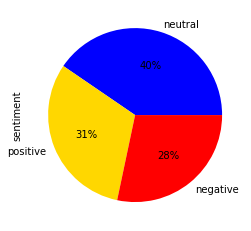

In [7]:
# visualize distribution
tweets_df.sentiment.value_counts().plot(kind='pie', autopct='%1.0f%%', colors=['blue', 'gold', 'red'])

In [8]:
# transform the sentiment column into numbers
dict_sentiment = {'positive': 1, 'neutral': 0, 'negative': -1}
tweets_df['sentiment'] = tweets_df['sentiment'].apply(lambda x: dict_sentiment.get(x))

# view updated dataframe
tweets_df.head()

,text,sentiment
0,id responded going,0
1,sooo sad miss san diego,-1
2,bos bullying,-1
3,interview leave alone,-1
4,son couldnt put release already bought,-1


In [9]:
# create a separate data frame without neutral tweets
tweets_no_neut = tweets_df[tweets_df["sentiment"] != 0]

<AxesSubplot:ylabel='sentiment'>

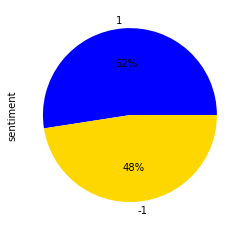

In [10]:
# visualize distribution - without neutral sentiment
tweets_no_neut.sentiment.value_counts().plot(kind='pie', autopct='%1.0f%%', colors=['blue', 'gold', 'red'])

In [11]:
# Create the X and y data 
def create_train_test_data (tweets_df, train_size):
    
    # assign X and y to the input and target columns
    X = tweets_df['text']
    y = tweets_df['sentiment']

    # split the data into testing data and training data
    if train_size == 0:
        X_train, X_test, y_train, y_test = train_test_split(X, y)
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size)

    # transform the data into tfidf vectors
    # fit the tfidf vectorizer on the training data to avoid bias
    vectorizer = TfidfVectorizer()
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)
    
    return X_train_tfidf, X_test_tfidf, y_train, y_test

In [12]:
# create the model
def create_model(tweets_df, attempt_num, model, train_size):
    # Get the train and test data
    
    X_train_tfidf, X_test_tfidf, y_train, y_test = create_train_test_data (tweets_df, train_size)

    # create a logistic regression model and fit it to the training data
    
    model.fit(X_train_tfidf, y_train)
    training_score, testing_score = evaluate(model, X_train_tfidf, y_train, X_test_tfidf, y_test, attempt_num)
    
    return training_score, testing_score

In [13]:
# evaluate the model
def evaluate(model, X_train_tfidf, y_train, X_test_tfidf, y_test, attempt_num):
    
    training_score = model.score(X_train_tfidf, y_train)
    testing_score = model.score(X_test_tfidf, y_test)
    
    # look at the scores for the testing and training data
    print(f"Attempt {attempt_num} ----------------------------------------")
    print(f"Training Data Score: {model.score(X_train_tfidf, y_train)}")
    print(f"Testing Data Score: {model.score(X_test_tfidf, y_test)} \n")

    # find metrics for testing data
    print(confusion_matrix(y_test.values, model.predict(X_test_tfidf)))
    print(classification_report(y_test.values, model.predict(X_test_tfidf)))
    
    return training_score, testing_score

In [14]:
# create dataframe for attempts
performance_df = pd.DataFrame(columns=["Model", "Attempt Number", "Training Score", "Testing Score", "Parameters"])
performance_df.head()

,Model,Attempt Number,Training Score,Testing Score,Parameters


## Logistic Regression

In [16]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()

training_score, testing_score = create_model(tweets_df, 1, model, 0)

# add to performance dataframe
performance_df.loc[len(performance_df.index)] = ['Logistic Regression', 1, training_score, testing_score, 'including neutrals']

training_score, testing_score = create_model(tweets_no_neut, 2, model, 0)

# add to performance dataframe
performance_df.loc[len(performance_df.index)] = ['Logistic Regression', 2, training_score, testing_score, 'excluding neutrals']

C:\Users\apfle\anaconda3\envs\PythonData\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Attempt 1 ----------------------------------------
Training Data Score: 0.8210092188258127
Testing Data Score: 0.6888371416096638 

[[1162  684  118]
 [ 359 2123  332]
 [  82  563 1448]]
              precision    recall  f1-score   support

          -1       0.72      0.59      0.65      1964
           0       0.63      0.75      0.69      2814
           1       0.76      0.69      0.73      2093

    accuracy                           0.69      6871
   macro avg       0.71      0.68      0.69      6871
weighted avg       0.70      0.69      0.69      6871

Attempt 2 ----------------------------------------
Training Data Score: 0.932529335071708
Testing Data Score: 0.8670251772182841 

[[1701  268]
 [ 276 1846]]
              precision    recall  f1-score   support

          -1       0.86      0.86      0.86      1969
           1       0.87      0.87      0.87      2122

    accuracy                           0.87      4091
   macro avg       0.87      0.87      0.87      4091
we

In [17]:
performance_df

,Model,Attempt Number,Training Score,Testing Score,Parameters
0,Logistic Regression,1,0.821009,0.688837,including neutrals
1,Logistic Regression,2,0.932529,0.867025,excluding neutrals


## Random Forest Classifier

In [18]:
from sklearn.ensemble import RandomForestClassifier

twitter_classi = RandomForestClassifier(n_estimators=300, random_state=0)

training_score, testing_score = create_model(tweets_df, 1, twitter_classi, train_size=.8)
performance_df.loc[len(performance_df.index)] = ['Random Forest', 1, training_score, testing_score, 'including neutrals']

training_score, testing_score = create_model(tweets_no_neut, 2, twitter_classi, train_size=.8)
performance_df.loc[len(performance_df.index)] = ['Random Forest', 2, training_score, testing_score, 'excluding neutrals']

Attempt 1 ----------------------------------------
Training Data Score: 0.9973617176128093
Testing Data Score: 0.7023831180643988 

[[ 853  518  108]
 [ 256 1726  306]
 [  68  380 1282]]
              precision    recall  f1-score   support

          -1       0.72      0.58      0.64      1479
           0       0.66      0.75      0.70      2288
           1       0.76      0.74      0.75      1730

    accuracy                           0.70      5497
   macro avg       0.71      0.69      0.70      5497
weighted avg       0.71      0.70      0.70      5497

Attempt 2 ----------------------------------------
Training Data Score: 0.9995416348357525
Testing Data Score: 0.8472349526428353 

[[1345  210]
 [ 290 1428]]
              precision    recall  f1-score   support

          -1       0.82      0.86      0.84      1555
           1       0.87      0.83      0.85      1718

    accuracy                           0.85      3273
   macro avg       0.85      0.85      0.85      3273
w

## Extra Trees Classifier

In [19]:
from sklearn.ensemble import ExtraTreesClassifier

twitter_ex = ExtraTreesClassifier(random_state=1)

training_score, testing_score = create_model(tweets_df, 1, twitter_ex, train_size=.8)
performance_df.loc[len(performance_df.index)] = ['Extreme Trees', 1, training_score, testing_score, 'including neutrals']

training_score, testing_score = create_model(tweets_no_neut, 2, twitter_ex, train_size=.8)
performance_df.loc[len(performance_df.index)] = ['Extreme Trees', 2, training_score, testing_score, 'excluding neutrals']

Attempt 1 ----------------------------------------
Training Data Score: 0.9974981804949054
Testing Data Score: 0.7096598144442423 

[[ 949  495  109]
 [ 262 1660  281]
 [  60  389 1292]]
              precision    recall  f1-score   support

          -1       0.75      0.61      0.67      1553
           0       0.65      0.75      0.70      2203
           1       0.77      0.74      0.75      1741

    accuracy                           0.71      5497
   macro avg       0.72      0.70      0.71      5497
weighted avg       0.72      0.71      0.71      5497

Attempt 2 ----------------------------------------
Training Data Score: 0.9995416348357525
Testing Data Score: 0.8646501680415521 

[[1363  187]
 [ 256 1467]]
              precision    recall  f1-score   support

          -1       0.84      0.88      0.86      1550
           1       0.89      0.85      0.87      1723

    accuracy                           0.86      3273
   macro avg       0.86      0.87      0.86      3273
w

## Ada Boost Classifier

In [20]:
from sklearn.ensemble import AdaBoostClassifier
twitter_ada = AdaBoostClassifier(random_state=1)

training_score, testing_score = create_model(tweets_df, 1, twitter_ada, train_size=.8)
performance_df.loc[len(performance_df.index)] = ['Ada Boost', 1, training_score, testing_score, 'including neutrals']

training_score, testing_score = create_model(tweets_no_neut, 2, twitter_ada, train_size=.8)
performance_df.loc[len(performance_df.index)] = ['Ada Boost', 2, training_score, testing_score, 'excluding neutrals']

Attempt 1 ----------------------------------------
Training Data Score: 0.6552492721979621
Testing Data Score: 0.6539930871384392 

[[ 650  809   98]
 [ 191 1840  258]
 [  43  503 1105]]
              precision    recall  f1-score   support

          -1       0.74      0.42      0.53      1557
           0       0.58      0.80      0.68      2289
           1       0.76      0.67      0.71      1651

    accuracy                           0.65      5497
   macro avg       0.69      0.63      0.64      5497
weighted avg       0.68      0.65      0.65      5497

Attempt 2 ----------------------------------------
Training Data Score: 0.806646294881589
Testing Data Score: 0.8050717995722578 

[[1426  143]
 [ 495 1209]]
              precision    recall  f1-score   support

          -1       0.74      0.91      0.82      1569
           1       0.89      0.71      0.79      1704

    accuracy                           0.81      3273
   macro avg       0.82      0.81      0.80      3273
we

In [21]:
performance_df

,Model,Attempt Number,Training Score,Testing Score,Parameters
0,Logistic Regression,1,0.821009,0.688837,including neutrals
1,Logistic Regression,2,0.932529,0.867025,excluding neutrals
2,Random Forest,1,0.997362,0.702383,including neutrals
3,Random Forest,2,0.999542,0.847235,excluding neutrals
4,Extreme Trees,1,0.997498,0.709660,including neutrals
5,Extreme Trees,2,0.999542,0.864650,excluding neutrals
6,Ada Boost,1,0.655249,0.653993,including neutrals
7,Ada Boost,2,0.806646,0.805072,excluding neutrals


# Naive Bayes

In [22]:
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()

training_score, testing_score = create_model(tweets_df,1,mnb,train_size=0.8)
performance_df.loc[len(performance_df.index)] = ['Multinomial Naive Bayes', 1, training_score, testing_score, 'including neutrals']

training_score, testing_score = create_model(tweets_no_neut,2,mnb,train_size=0.8)
performance_df.loc[len(performance_df.index)] = ['Multinomial Naive Bayes', 2, training_score, testing_score, 'excluding neutrals']

Attempt 1 ----------------------------------------
Training Data Score: 0.7912572780203785
Testing Data Score: 0.6090594869929052 

[[ 596  931   82]
 [ 127 1795  227]
 [  34  748  957]]
              precision    recall  f1-score   support

          -1       0.79      0.37      0.50      1609
           0       0.52      0.84      0.64      2149
           1       0.76      0.55      0.64      1739

    accuracy                           0.61      5497
   macro avg       0.69      0.59      0.59      5497
weighted avg       0.67      0.61      0.60      5497

Attempt 2 ----------------------------------------
Training Data Score: 0.9411764705882353
Testing Data Score: 0.8567063855789795 

[[1254  299]
 [ 170 1550]]
              precision    recall  f1-score   support

          -1       0.88      0.81      0.84      1553
           1       0.84      0.90      0.87      1720

    accuracy                           0.86      3273
   macro avg       0.86      0.85      0.86      3273
w

In [23]:
performance_df

,Model,Attempt Number,Training Score,Testing Score,Parameters
0,Logistic Regression,1,0.821009,0.688837,including neutrals
1,Logistic Regression,2,0.932529,0.867025,excluding neutrals
2,Random Forest,1,0.997362,0.702383,including neutrals
3,Random Forest,2,0.999542,0.847235,excluding neutrals
4,Extreme Trees,1,0.997498,0.709660,including neutrals
5,Extreme Trees,2,0.999542,0.864650,excluding neutrals
6,Ada Boost,1,0.655249,0.653993,including neutrals
7,Ada Boost,2,0.806646,0.805072,excluding neutrals
8,Multinomial Naive Bayes,1,0.791257,0.609059,including neutrals
9,Multinomial Naive Bayes,2,0.941176,0.856706,excluding neutrals
